In [1]:
%load_ext autoreload

In [2]:
%autoreload 3
import os
import time
from itertools import islice, permutations, product
from importlib import reload
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from tensorflow.contrib.layers import fully_connected, flatten

from magnolia.features.mixer import FeatureMixer
from magnolia.features.wav_iterator import batcher
import magnolia.features.spectral_features as sf
reload(sf)
from magnolia.utils.tf_bits import scope
from magnolia.factorization.pit import PITModel

%matplotlib inline

In [3]:
num_srcs = 2
num_steps = 51
num_freq_bins = 257
batch_size = 256

checkpoint_path = "/local_data/pcallier/pit_checkpoint"

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def scale_spectrogram(spectrogram):
    mag_spec = np.abs(spectrogram)
    phases = np.unwrap(np.angle(spectrogram))
    
    mag_spec = np.sqrt(mag_spec)
    M = mag_spec.max()
    m = mag_spec.min()
    
    return (mag_spec - m)/(M - m), phases

In [4]:
tf.reset_default_graph()

model_name = "pit_cnn_{}spkr".format(num_srcs)
model = PITModel('pit-s-cnn', num_srcs, num_steps, num_freq_bins, learning_rate=5e-4)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = []
val_losses = []
weight_changes = []

Tensor("cnn_mask/ExpandDims:0", shape=(?, 51, 257, 1), dtype=float32, device=/device:GPU:0)
Tensor("cnn_mask/maxpool11:0", shape=(?, 3, 11, 256), dtype=float32, device=/device:GPU:0)
Tensor("cnn_mask/Flatten/Reshape:0", shape=(?, 8448), dtype=float32, device=/device:GPU:0)
Tensor("cnn_mask/dense12/BiasAdd:0", shape=(?, 1024), dtype=float32, device=/device:GPU:0)
Masks
Tensor("cnn_mask/dense/BiasAdd:0", shape=(?, 26214), dtype=float32, device=/device:GPU:0)
Tensor("cnn_mask/Reshape:0", shape=(?, 2, 51, 257), dtype=float32, device=/device:GPU:0)
Tensor("cnn_mask/transpose:0", shape=(2, ?, 51, 257), dtype=float32, device=/device:GPU:0)
Tensor("cnn_mask/truediv:0", shape=(2, ?, 51, 257), dtype=float32, device=/device:GPU:0)
reconstructions
Tensor("cnn_mask/transpose_1:0", shape=(?, 2, 51, 257), dtype=float32, device=/device:GPU:0)
Losses
Tensor("loss/strided_slice:0", shape=(?, 51, 257), dtype=float32, device=/device:GPU:0)
Tensor("loss/strided_slice_1:0", shape=(?, 51, 257), dtype=float32

In [13]:
librispeech_dev = "/local_data/teams/magnolia/librispeech/processed_dev-clean.h5"
librispeech_train = "/local_data/teams/magnolia/librispeech/processed_train-clean-100.h5"

mixed_features = FeatureMixer([librispeech_train] * num_srcs, shape=(num_steps, None))
mixed_features_val = FeatureMixer([librispeech_dev] * num_srcs, shape=(num_steps, None))
data_batches = batcher(mixed_features, batch_size)
val_batches = batcher(mixed_features_val, batch_size)

## 3 speakers

In [14]:
%pdb off
prev_first_layer_weights = None
prev_weights = None
saver = tf.train.Saver()
nbatches = 100000 if num_srcs == 3 else 0
for i, batch in enumerate(islice(data_batches, nbatches)):
    
    # Get training data
    batch_features, batch_ref1, batch_ref2, batch_ref3 = batch
    batch_ref1_norm, batch_ref1_norm_phase = scale_spectrogram(batch_ref1) 
    batch_ref2_norm, batch_ref2_norm_phase = scale_spectrogram(batch_ref2)
    batch_ref3_norm, batch_ref3_norm_phase = scale_spectrogram(batch_ref3)
    batch_features_norm, batch_features_norm_phase = scale_spectrogram(batch_features)
    
    # Do optimization
    data = { 
        model.X_in: batch_features_norm,
        model.y_in: np.stack((batch_ref1_norm, batch_ref2_norm, batch_ref3_norm), axis=1)
        }
    sess.run(model.optimize, feed_dict=data)
    loss = sess.run(model.loss, feed_dict=data)
    losses.append(loss)
    
    # get validation statistics
    val_batch = next(val_batches)
    (val_feat_norm, _), (val_ref1_norm, _), (val_ref2_norm, _), (val_ref3_norm, _) = \
        [scale_spectrogram(x) for x in val_batch]
    val_data = { model.X_in: val_feat_norm, 
                model.y_in: np.stack((val_ref1_norm, val_ref2_norm, val_ref3_norm), axis=1)}
    val_loss = sess.run(model.loss, feed_dict=val_data)
    val_losses.append(val_loss)
    
    # Collect predictions, gradient statistics, masks
    prediction = sess.run(model.predict, data)
    all_weights = sess.run(tf.concat([tf.reshape(var, [-1]) for var in tf.trainable_variables()], axis=0), data)
    if prev_weights is not None:
        weight_changes.append(np.linalg.norm(all_weights-prev_weights))
    prev_weights = all_weights
    if model.mask is not None:
        masks = sess.run(model.mask, data)
    else:
        masks = None
    
    # Checkpointing
    if len(losses) > 0 and len(losses) % 1000 == 0:
#     if True:
        saver.save(sess, os.path.join(checkpoint_path, "{model}_{batch}_{stamp}.ckpt".format(
            model=model_name,
            batch=i,
            stamp=hex(hash(time.time()))[2:8]
        )))
    
    # Plotting
    if len(losses) > 0 and len(losses) % 10 == 0:
#     if True:
        orig = sf.reconstruct(batch_features[0], batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        recon_a = sf.reconstruct(prediction[0,0]**2, batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        recon_b = sf.reconstruct(prediction[0,1]**2, batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        recon_c = sf.reconstruct(prediction[0,2]**2, batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        orig_a = sf.reconstruct(batch_ref1[0], batch_ref1[0], fs=10000, window_size=None, step_size=0.0256)
        orig_b = sf.reconstruct(batch_ref2[0], batch_ref2[0], fs=10000, window_size=None, step_size=0.0256)
        orig_c = sf.reconstruct(batch_ref3[0], batch_ref3[0], fs=10000, window_size=None, step_size=0.0256)
        
        display.clear_output(wait=True)
        plt.figure(figsize=(8,9))
        plt.subplot(3,4,1); plt.imshow(np.sqrt(prediction[0,0].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,2); plt.imshow(np.sqrt(prediction[0,1].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,3); plt.imshow(np.sqrt(prediction[0,2].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,4); plt.imshow(batch_features_norm[0].T, cmap='bone', origin='lower', aspect=0.25)
        if masks is not None:
            plt.subplot(3,4,5); plt.imshow(masks[0,0].T, cmap='bone', origin='lower', aspect=0.25, vmin=0, vmax=1)
            plt.subplot(3,4,6); plt.imshow(masks[1,0].T, cmap='bone', origin='lower', aspect=0.25, vmin=0, vmax=1)
            plt.subplot(3,4,7); plt.imshow(masks[2,0].T, cmap='bone', origin='lower', aspect=0.25, vmin=0, vmax=1)
            plt.subplot(3,4,8); plt.imshow(masks[2,1].T, cmap='bone', origin='lower', aspect=0.25, vmin=0, vmax=1)
            plt.title("Next example")
            
        plt.subplot(3,4,9); plt.imshow(batch_ref1_norm[0].T, cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,10); plt.imshow(batch_ref2_norm[0].T, cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,11); plt.imshow(batch_ref3_norm[0].T, cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,12); plt.imshow(batch_features_norm[1].T, cmap='bone', origin='lower', aspect=0.25)
        
        
        
        smooth_factor = len(losses) // 10
        if smooth_factor <= 5:
            avg_losses = losses
            avg_val = val_losses
            avg_chg = weight_changes
        else:
            avg_losses = moving_average(losses, smooth_factor)
            avg_val = moving_average(losses)
            avg_chg = moving_average(weight_changes, smooth_factor)
        plt.figure(figsize=(8,5))
        plt.plot(avg_losses)
        plt.plot(avg_val, color='red')
        plt.title("Losses")
        
        plt.figure(figsize=(8,5))
        plt.plot(avg_chg)
        plt.title("Norm of weight changes from previous minibatch")
        
        plt.figure()
        plt.imshow(sess.run(model.logits, data), cmap='afmhot', aspect=3)
        plt.colorbar()
        plt.show()
        print("Mix")
        display.display(display.Audio(orig, rate=10000))
        print("Recon A")
        display.display(display.Audio(recon_a, rate=10000))
        print("Recon B")
        display.display(display.Audio(recon_b, rate=10000))
        print("Recon C")
        display.display(display.Audio(recon_c, rate=10000))
        print("Originals")
        display.display(display.Audio(orig_a, rate=10000))
        display.display(display.Audio(orig_b, rate=10000))
        display.display(display.Audio(orig_c, rate=10000))

Automatic pdb calling has been turned OFF


## 2 speakers

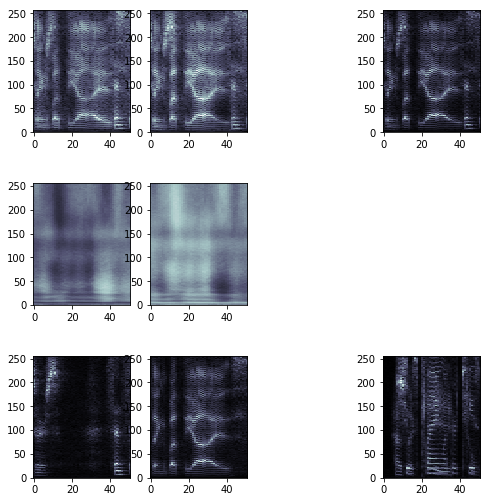

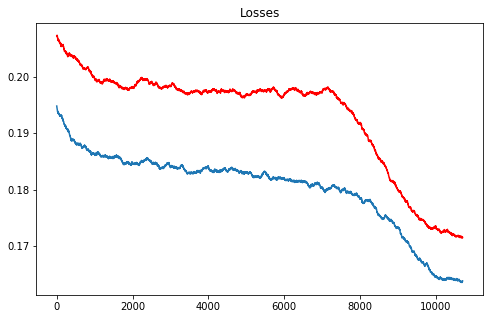

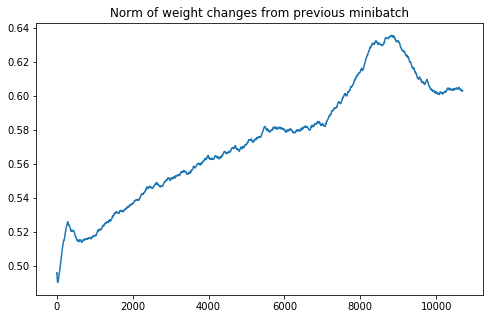

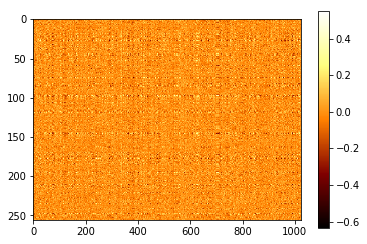

Mix


Recon A


Recon B


Originals


In [ ]:
%pdb off
prev_first_layer_weights = None
prev_weights = None
saver = tf.train.Saver()
nbatches = 100000 if num_srcs == 2 else 0
for i, batch in enumerate(islice(data_batches, nbatches)):
    
    # Get training data
    batch_features, batch_ref1, batch_ref2 = batch
    batch_ref1_norm, batch_ref1_norm_phase = scale_spectrogram(batch_ref1) 
    batch_ref2_norm, batch_ref2_norm_phase = scale_spectrogram(batch_ref2)
    batch_features_norm, batch_features_norm_phase = scale_spectrogram(batch_features)
    
    # Do optimization
    data = { 
        model.X_in: batch_features_norm,
        model.y_in: np.stack((batch_ref1_norm, batch_ref2_norm), axis=1)
        }
    sess.run(model.optimize, feed_dict=data)
    loss = sess.run(model.loss, feed_dict=data)
    losses.append(loss)
    
    # get validation statistics
    val_batch = next(val_batches)
    (val_feat_norm, _), (val_ref1_norm, _), (val_ref2_norm, _) = \
        [scale_spectrogram(x) for x in val_batch]
    val_data = { model.X_in: val_feat_norm, 
                model.y_in: np.stack((val_ref1_norm, val_ref2_norm), axis=1)}
    val_loss = sess.run(model.loss, feed_dict=val_data)
    val_losses.append(val_loss)
    
    # Collect predictions, gradient statistics, masks
    prediction = sess.run(model.predict, data)
    all_weights = sess.run(tf.concat([tf.reshape(var, [-1]) for var in tf.trainable_variables()], axis=0), data)
    if prev_weights is not None:
        weight_changes.append(np.linalg.norm(all_weights-prev_weights))
    prev_weights = all_weights
    if model.mask is not None:
        masks = sess.run(model.mask, data)
    else:
        masks = None
    
    # Checkpointing
    if len(losses) > 0 and len(losses) % 1000 == 0:
#     if True:
        saver.save(sess, os.path.join(checkpoint_path, "{model}_{batch}_{stamp}.ckpt".format(
            model=model_name,
            batch=i,
            stamp=hex(hash(time.time()))[2:8]
        )))
    
    # Plotting
    if len(losses) > 0 and len(losses) % 10 == 0:
#     if True:
        orig = sf.reconstruct(batch_features[0], batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        recon_a = sf.reconstruct(prediction[0,0]**2, batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        recon_b = sf.reconstruct(prediction[0,1]**2, batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        orig_a = sf.reconstruct(batch_ref1[0], batch_ref1[0], fs=10000, window_size=None, step_size=0.0256)
        orig_b = sf.reconstruct(batch_ref2[0], batch_ref2[0], fs=10000, window_size=None, step_size=0.0256)
        
        display.clear_output(wait=True)
        plt.figure(figsize=(8,9))
        plt.subplot(3,4,1); plt.imshow(np.sqrt(prediction[0,0].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,2); plt.imshow(np.sqrt(prediction[0,1].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,4); plt.imshow(batch_features_norm[0].T, cmap='bone', origin='lower', aspect=0.25)
        if masks is not None:
            plt.subplot(3,4,5); plt.imshow(masks[0,0].T, cmap='bone', origin='lower', aspect=0.25, vmin=0, vmax=1)
            plt.subplot(3,4,6); plt.imshow(masks[1,0].T, cmap='bone', origin='lower', aspect=0.25, vmin=0, vmax=1)
            
        plt.subplot(3,4,9); plt.imshow(batch_ref1_norm[0].T, cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(3,4,10); plt.imshow(batch_ref2_norm[0].T, cmap='bone', origin='lower', aspect=0.25)
        
        
        smooth_factor = len(losses) // 10
        if smooth_factor <= 5:
            avg_losses = losses
            avg_val = val_losses
            avg_chg = weight_changes
        else:
            avg_losses = moving_average(losses, smooth_factor)
            avg_val = moving_average(val_losses, smooth_factor)
            avg_chg = moving_average(weight_changes, smooth_factor)
        plt.figure(figsize=(8,5))
        plt.plot(avg_losses)
        plt.plot(avg_val, color='red')
        plt.title("Losses")
        
        plt.figure(figsize=(8,5))
        plt.plot(avg_chg)
        plt.title("Norm of weight changes from previous minibatch")
        
        plt.figure()
        plt.imshow(sess.run(model.logits, data), cmap='afmhot', aspect=3)
        plt.colorbar()
        plt.show()
        print("Mix")
        display.display(display.Audio(orig, rate=10000))
        print("Recon A")
        display.display(display.Audio(recon_a, rate=10000))
        print("Recon B")
        display.display(display.Audio(recon_b, rate=10000))

        print("Originals")
        display.display(display.Audio(orig_a, rate=10000))
        display.display(display.Audio(orig_b, rate=10000))
